In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
def data_preparation(data):
    df = pd.read_csv(data)
    df = df.sample(n= 6000, random_state=1)
    y = df.pop('power')
    y = y.values
    y = y.reshape(-1,1)
    X = df.values
    X = df
    return X, y

In [3]:
seed = 23
X, y = data_preparation('train.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= seed)

scaler1 = MinMaxScaler()
X_train = scaler1.fit_transform(X_train)
X_val = scaler1.transform(X_val)
X_test = scaler1.transform(X_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_val = scaler2.transform(y_val)
y_test = scaler2.transform(y_test)

In [5]:
#X_small_shift, y_small_shift = data_preparation('dev_in.csv')
X_shift, y_shift = data_preparation('dev_out.csv')

X_shift = scaler1.transform(X_shift)
y_shift = scaler2.transform(y_shift)

In [6]:
# Generate OOD data

In [7]:
# Sonar.csv
OOD = pd.read_csv('Boston_Housing_test.csv')
OOD = OOD.iloc[:, 1:12]
OOD = OOD.values
OOD = scaler1.transform(OOD)


/home/user/anaconda3/envs/xue_long_tf/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [8]:
# pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

In [9]:
import matplotlib.pyplot as plt
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf
tf.autograph.set_verbosity(0)
import official.nlp.modeling.layers as nlp_layers

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

2023-12-12 22:32:04.683453: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 22:32:04.699027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 22:32:04.699041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 22:32:04.699482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 22:32:04.702404: I tensorflow/core/platform/cpu_feature_guar

In [10]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers= 3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return hidden, self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [11]:
resnet_config = dict(num_classes = 1, num_layers= 3, num_hidden= 128) # （2 64  0.007） （2 32 0.006）
resnet_model = DeepResNet(**resnet_config)
resnet_model.build( (None, 11) )
resnet_model.summary()

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  1536      
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  16512     
                                                                 
 dense_3 (Dense)             multiple                  16512     
                                                                 
 dense_4 (Dense)             multiple                  129       
                                                                 
Total params: 51201 (200.00 KB)
Trainable params: 49665 (194.00 KB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


2023-12-12 22:32:05.439560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 22:32:05.457347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 22:32:05.457459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanSquaredError()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100,
                                            restore_best_weights = True)

fit_config = dict( batch_size= 64,  epochs= 1000,
                validation_data = (X_val, y_val),
                callbacks=[callback] )

In [13]:
resnet_model.compile(**train_config)
history = resnet_model.fit( x = X_train, y = y_train,
                           **fit_config )

Epoch 1/1000
68/68 [==============================] - 1s 3ms/step - loss: 0.4013 - output_1_loss: 0.2218 - output_2_loss: 0.1796 - output_1_mean_squared_error: 0.2218 - output_2_mean_squared_error: 0.1796 - val_loss: 0.2251 - val_output_1_loss: 0.1963 - val_output_2_loss: 0.0288 - val_output_1_mean_squared_error: 0.1963 - val_output_2_mean_squared_error: 0.0288
Epoch 2/1000
68/68 [==============================] - 0s 2ms/step - loss: 0.2353 - output_1_loss: 0.1927 - output_2_loss: 0.0426 - output_1_mean_squared_error: 0.1927 - output_2_mean_squared_error: 0.0426 - val_loss: 0.1693 - val_output_1_loss: 0.1592 - val_output_2_loss: 0.0101 - val_output_1_mean_squared_error: 0.1592 - val_output_2_mean_squared_error: 0.0101
Epoch 3/1000
68/68 [==============================] - 0s 2ms/step - loss: 0.1858 - output_1_loss: 0.1558 - output_2_loss: 0.0300 - output_1_mean_squared_error: 0.1558 - output_2_mean_squared_error: 0.0300 - val_loss: 0.1306 - val_output_1_loss: 0.1231 - val_output_2_loss:

<Axes: >

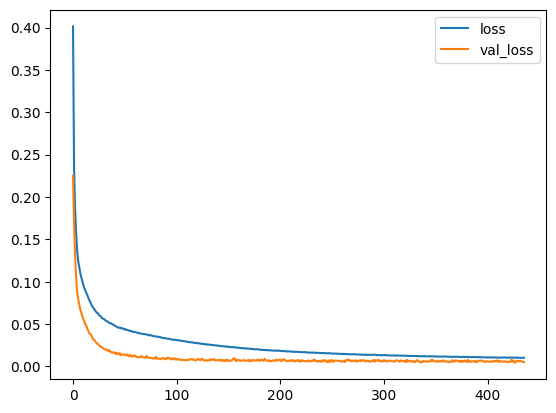

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

# print(("Best Validation Loss: {:0.4f}" +\
#       "\nBest Validation Accuracy: {:0.4f}")\
#       .format(history_df['val_loss'].min(),
#               history_df['val_sparse_categorical_accuracy'].max()))

In [15]:
def NN_mse(X, y):
    hidden, preds = resnet_model.predict(X)
    mse = mean_squared_error(y, preds)
    print(f'mse -- {mse}')
    return mse

NN_accuracy_test = NN_mse(X_test, y_test)
NN_accuracy_shift = NN_mse(X_shift, y_shift)

38/38 [==============================] - 0s 492us/step
mse -- 0.0015773550258433343
188/188 [==============================] - 0s 383us/step
mse -- 0.0031976336934833303


In [16]:
# SNGP

In [17]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_kernel_scale = 100.0,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    hidden, (logits, covmat) = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return hidden, logits, covmat

    return logits

In [18]:
# Implement a Keras callback to reset the covariance matrix at the beginning of a new epoch.

In [19]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [20]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())
    return super().fit(*args, **kwargs)

In [21]:
# Train model

In [22]:
# fit_config = dict( batch_size= 64,  epochs= 1000,
#                 validation_data = (X_val, y_val),
#                 callbacks=[callback] ) # batch_size= 512

sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
history = sngp_model.fit(X_train, y_train, **fit_config)

Epoch 1/1000
68/68 [==============================] - 1s 4ms/step - loss: 0.0658 - mean_squared_error: 0.0658 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 2/1000
68/68 [==============================] - 0s 2ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 3/1000
68/68 [==============================] - 0s 3ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 4/1000
68/68 [==============================] - 0s 3ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 5/1000
68/68 [==============================] - 0s 3ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 6/1000
68/68 [==============================] - 0s 1ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 7/1000
68/68 [========

<Axes: >

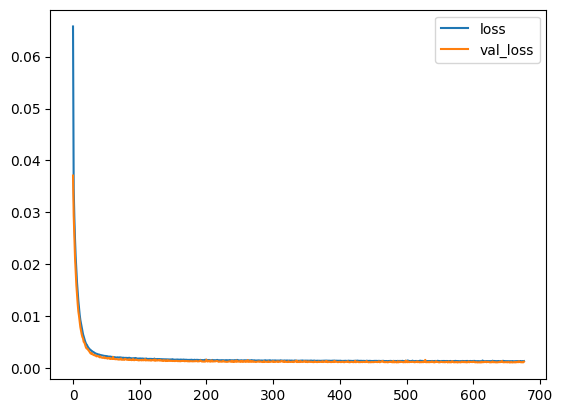

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()

In [24]:
# # This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:

# def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
#   # Computes uncertainty-adjusted logits using the built-in method.
#   logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
#       logits, covmat, mean_field_factor=lambda_param)

#   return logits_adjusted

In [25]:
def compute_variance(x):
  hidden, sngp_logits, sngp_covmat = sngp_model(x, return_covmat=True)

  sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

  mean_var = np.mean(sngp_variance)
  print(f'mean variance -- {mean_var}')

  # print(hidden.shape)
  # print(sngp_variance)
  return hidden, sngp_variance

train_hidden_sngp, train_var_sngp = compute_variance(X_train)
test_hidden_sngp, test_var_sngp = compute_variance(X_test)
shift_hidden_sngp, shift_var_sngp = compute_variance(X_shift)
OOD_hidden_sngp, OOD_var_sngp = compute_variance(OOD)


#train_var_sngp = train_var_sngp.numpy().ravel()
test_var_sngp = test_var_sngp.numpy().ravel()
shift_var_sngp = shift_var_sngp.numpy().ravel()
OOD_var_sngp = OOD_var_sngp.numpy().ravel()

mean variance -- 0.0017394731985405087


mean variance -- 0.001767933601513505
mean variance -- 0.003516973927617073
mean variance -- 0.36574944853782654


2023-12-12 22:34:57.108406: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55dfb241c560


In [26]:
def compute_mse(model, X, y):
  hidden, sngp_logits, sngp_covmat = model(X, return_covmat=True)
  # preds = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
  mse = mean_squared_error(y, sngp_logits)
  print(f'mse -- {mse}')
  return
compute_mse(sngp_model, X_test, y_test)
compute_mse(sngp_model, X_shift, y_shift)

mse -- 0.0012698224512589058
mse -- 0.002262419121307845


In [27]:
# Compute distance

In [28]:
def compute_distane(train_hidden, test_hidden, k = 10):
    distances = tf.norm(tf.expand_dims(test_hidden, axis=1) - tf.expand_dims(train_hidden, axis=0), axis=-1)
    topk_distances, topk_indices = tf.math.top_k(-distances, k=k)  # Use negative distances for smallest k distances
    return - topk_distances

In [30]:
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
           
test_distance = compute_distane(X_train, X_test)
shift_distance = compute_distane(X_train, X_shift)
OOD_distance = compute_distane(X_train, OOD)

# Compute mean along axis = 1 (rows)
test_mean_inp = tf.reduce_mean(test_distance, axis=1).numpy()
shift_mean_inp = tf.reduce_mean(shift_distance, axis=1).numpy()
OOD_mean_inp = tf.reduce_mean(OOD_distance, axis=1).numpy()

2023-12-12 22:53:08.403444: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 435.06MiB (rounded to 456192000)requested by op Sub
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-12-12 22:53:08.403459: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-12-12 22:53:08.403463: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 100, Chunks in use: 95. 25.0KiB allocated for chunks. 23.8KiB in use in bin. 438B client-requested in use in bin.
2023-12-12 22:53:08.403466: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 30, Chunks in use: 29. 16.0KiB allocated for chunks. 15.5KiB in use in bin. 14.5KiB client-requested in use in bin.
2023-12-12 22:53:08.403468

ResourceExhaustedError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Sub] name: 

tor.cc:1095] InUse at 7f29dc180100 of size 256 next 144
2023-12-12 22:53:08.403718: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f29dc180200 of size 256 next 149
2023-12-12 22:53:08.403720: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f29dc180300 of size 256 next 151
2023-12-12 22:53:08.403721: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f29dc180400 of size 256 next 159
2023-12-12 22:53:08.403722: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f29dc180500 of size 256 next 163
2023-12-12 22:53:08.403723: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f29dc180600 of size 256 next 165
2023-12-12 22:53:08.403725: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f29dc180700 of size 256 next 167
2023-12-12 22:53:08.403726: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f29dc180800 of size 256 next 168
2023-12-12 22:53:08.403727: I external/lo

NameError: name 'test_mean_inp' is not defined

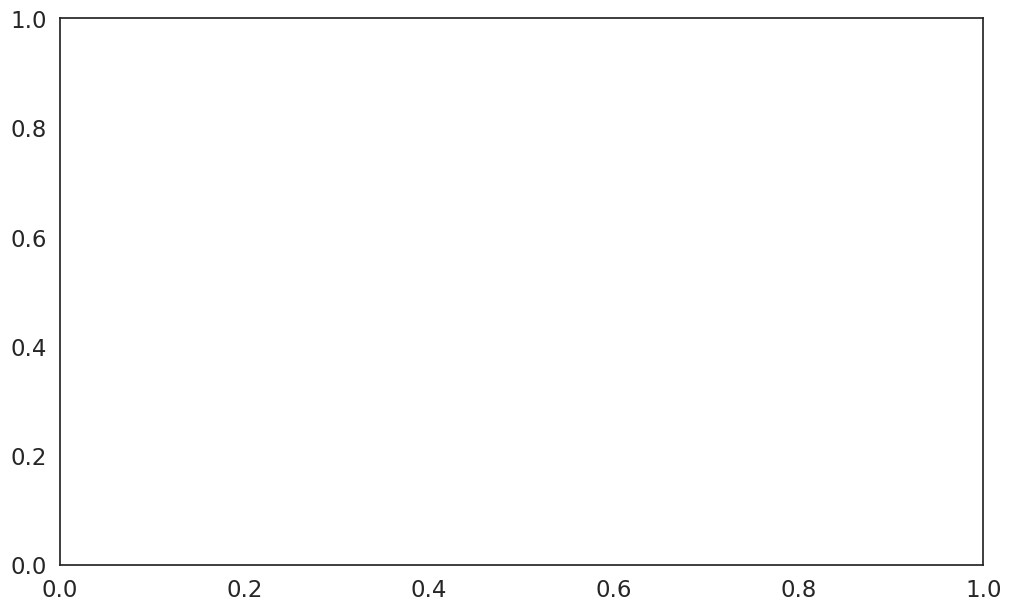

In [ ]:
sns.set(style="white", font_scale = 1.5 )
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')  #
#ax.set_xscale('log', base=2)

def plot_hidden_distance(ax, distance, label):
    ax.hist(distance, bins= 20, alpha= 0.5,  label = label)
    #ax.set_xscale('log', base=10)

    ax.legend()
    plt.xscale("log")

plot_hidden_distance(ax, test_mean_inp,  label = 'Normal') # density=True,
plot_hidden_distance(ax, shift_mean_inp,  label = 'Shift')
plot_hidden_distance(ax, OOD_mean_inp,  label = 'OOD')
plt.xlabel('Input distance')

plt.savefig('Input_dist_hist_reg.pdf')
plt.show()

In [ ]:
test_distance_sngp = compute_distane(train_hidden_sngp, test_hidden_sngp)
OOD_distance_sngp = compute_distane(train_hidden_sngp, OOD_hidden_sngp)
shift_distance_sngp = np.zeros((shift_hidden_sngp.shape[0], 10))
batches = int((shift_hidden_sngp.shape[0]/1000))
for i in range(batches):
    s = i*1000
    t = (i+1)*1000
    print (s, t)
    tmp = compute_distane(train_hidden_sngp, shift_hidden_sngp[s:t, :])
    shift_distance_sngp[s:t, :] = tmp

# Compute mean along axis 1 (rows)
test_mean_sngp = tf.reduce_mean(test_distance_sngp, axis=1).numpy()
shift_mean_sngp = tf.reduce_mean(shift_distance_sngp, axis=1).numpy()
OOD_mean_sngp = tf.reduce_mean(OOD_distance_sngp, axis=1).numpy()

print(test_hidden_sngp.shape)
print(shift_hidden_sngp.shape)
print(OOD_hidden_sngp.shape)

In [ ]:
def plot_hidden_distance_hist(test_mean_sngp , shift_mean_sngp, OOD_mean_sngp, name ):
    fig, ax = plt.subplots(figsize=(10, 6), layout='constrained' )
    ax.set_xscale('log', base=10)
    plt.hist(test_mean_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
    plt.hist(shift_mean_sngp, bins = 20, alpha= 0.5,  label = 'Shift')
    plt.hist((OOD_mean_sngp),   bins = 20, alpha= 0.5,  label = 'OOD')
    plt.xlabel('Hidden distance')
    plt.legend()
    plt.savefig(f'{name}')
    plt.show()
plot_hidden_distance_hist(test_mean_sngp , shift_mean_sngp, OOD_mean_sngp,  'Hidden_Dist_Hist_SNGP_reg.pdf' )


In [ ]:
def scatter_var_dist(test_dist, shift_dist, OOD_dist,  test_var, shift_var, OOD_var, name):
    fig, ax = plt.subplots(figsize=(10, 6), layout='constrained' )
    ax.set_xscale('log', base=10)
    plt.scatter(test_dist,  test_var,  alpha= 0.5,   label = 'Non-shift') #color = 'blue',color = 'orange',color = 'green',
    plt.scatter(shift_dist, shift_var, alpha= 0.5, label = 'Shift')
    plt.scatter(OOD_dist,  OOD_var,   alpha= 0.5, label = 'OOD')
    plt.xlabel('Hidden distance')
    plt.ylabel('Variance')

    plt.legend()
    plt.savefig(f'{name}')
    plt.show()
scatter_var_dist(test_mean_sngp, shift_mean_sngp, OOD_mean_sngp, test_var_sngp, shift_var_sngp, OOD_var_sngp, 'Dist_Var_SNGP_reg.pdf')

In [ ]:
def plot_variance_hist(test_var_sngp, shift_var_sngp, OOD_var_sngp, name):
    fig, ax = plt.subplots(figsize=(6, 4), layout='constrained' )
    ax.set_xscale('log', base=10)
    plt.hist(test_var_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
    plt.hist(shift_var_sngp, bins = 20, alpha= 0.5,  label = 'Shift')
    plt.hist(OOD_var_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')
    plt.xlabel('Variance')
    plt.legend()
    plt.savefig(f'{name}')
    plt.show()
plot_variance_hist(test_var_sngp, shift_var_sngp, OOD_var_sngp, 'SNGP_Var_reg.pdf')

In [ ]:
# MC Dropout

In [ ]:
num_ensemble = 10

In [ ]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

In [ ]:
# Monte Carlo dropout inference.

def Compute_MC(model, X, y):


  hidden = model(X)[0]
  preds = [ model(X)[1] for _ in range(num_ensemble) ]

  preds = np.hstack(preds)


  #predictions = tf.(predictions, axis=0)

  pred_mean = np.mean(preds, axis=1)

  vars = np.var(preds, axis=1)

  # # pred = pred_list.mean(axis = 1)
  mse = mean_squared_error(pred_mean, y)

  # # vars = [ np.var(i) for i in pred_list]
  mean_ = np.mean(vars)

  print(f'mse--{mse} vars--{mean_}')
  return hidden, vars

train_hidden_mc, var_mc = Compute_MC(mc_dropout_sampling, X_train, y_train)
test_hidden_mc, test_var_mc = Compute_MC(mc_dropout_sampling, X_test, y_test)
shift_hidden_mc, shift_var_mc = Compute_MC(mc_dropout_sampling, X_shift, y_shift)

In [ ]:
# OOD
def Compute_MC_OOD(model, X):
  hidden = model(X)[0]

  predictions = []
  predictions.append([model(X)[1] for _ in range(num_ensemble)])

  predictions = tf.concat(predictions, axis=0)

  vars = tf.math.reduce_variance(predictions, axis=0)

  mean_ = np.mean(vars)
  print(f'vars--{mean_}')
  return hidden, vars

OOD_hidden_mc, OOD_var_mc = Compute_MC_OOD(mc_dropout_sampling, OOD)

In [ ]:
test_distance_mc = compute_distane(train_hidden_mc, test_hidden_mc)
OOD_distance_mc = compute_distane(train_hidden_mc, OOD_hidden_mc)

shift_distance_mc = np.zeros((shift_hidden_mc.shape[0], 10))
batches = int((shift_hidden_mc.shape[0]/1000))
for i in range(batches):
    s = i*1000
    t = (i+1)*1000
    print (s, t)
    tmp = compute_distane(train_hidden_sngp, shift_hidden_mc[s:t, :])
    shift_distance_mc[s:t, :] = tmp



# compute mean along axis 1 (rows)
test_mean_mc = tf.reduce_mean(test_distance_mc, axis=1).numpy()
shift_mean_mc = tf.reduce_mean(shift_distance_mc, axis=1).numpy()
OOD_mean_mc = tf.reduce_mean(OOD_distance_mc, axis=1).numpy()


In [ ]:
# Deep ensemble

In [ ]:
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(X_train, y_train, verbose=0, **fit_config)
  resnet_ensemble.append(resnet_model)

In [ ]:
def Compute_Deep(model_list, X, y):

  hidden = [model(X)[0] for model in model_list]
  hidden = tf.reduce_mean(hidden, axis = 0)

  ensemble_predictions = np.array([model(X)[1] for model in model_list])

  mean_prediction = np.mean(ensemble_predictions, axis=0)
  vars = np.var(ensemble_predictions, axis=0)

  mse = mean_squared_error(mean_prediction, y)
  print(f'mse: {mse} -- Mean Variance:{np.mean(vars)}')
  return hidden, vars

train_hidden_deep, var = Compute_Deep(resnet_ensemble, X_train, y_train)
test_hidden_deep, test_var_deep = Compute_Deep(resnet_ensemble, X_test, y_test)
shift_hidden_deep, shift_var_deep = Compute_Deep(resnet_ensemble, X_shift, y_shift)

In [ ]:
def Compute_Deep_OOD(model_list, X):
  hidden = [ model(X)[0] for model in model_list]
  hidden = tf.reduce_mean(hidden, axis = 0)

  #print(ensemble_logit_samples)
  # pred_list = np.hstack([model(X)[1] for model in model_list])
  # vars = [ np.var(i) for i in pred_list]
  # vars = [ np.var(i) for i in pred_list]

  ensemble_predictions = np.array( [model(X)[1] for model in model_list])

  mean_prediction = np.mean(ensemble_predictions, axis=0)
  vars = np.var(ensemble_predictions, axis=0)

  print(f'Mean Variance:{np.mean(vars)}')

  return hidden, vars

OOD_hidden_deep, OOD_var_deep = Compute_Deep_OOD(resnet_ensemble, OOD)


In [ ]:
test_distance_deep = compute_distane(train_hidden_deep, test_hidden_deep)
#shift_distance_deep = compute_distane(train_hidden_deep, shift_hidden_deep)
OOD_distance_deep = compute_distane(train_hidden_deep, OOD_hidden_deep)

shift_distance_deep = np.zeros((shift_hidden_deep.shape[0], 10))
batches = int((shift_hidden_deep.shape[0]/1000))
for i in range(batches):
    s = i*1000
    t = (i+1)*1000
    print (s, t)
    tmp = compute_distane(train_hidden_sngp, shift_hidden_deep[s:t, :])
    shift_distance_deep[s:t, :] = tmp

# compute mean along axis 1 (rows)
test_mean_deep = tf.reduce_mean(test_distance_deep, axis=1).numpy()
shift_mean_deep = tf.reduce_mean(shift_distance_deep, axis=1).numpy()
OOD_mean_deep = tf.reduce_mean(OOD_distance_deep, axis=1).numpy()

In [ ]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4.5), layout='constrained' ) # 11.69,8.27

ax1.hist(test_mean_inp, bins = 20, alpha= 0.6, label = 'Normal') # density=True,
ax1.hist(shift_mean_inp, bins = 20, alpha= 0.6, label = 'Shift')
ax1.hist(OOD_mean_inp, alpha= 0.6, label = 'OOD')
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Distance in the input space', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
ax1.set_title('(a) Histogram of distance', fontweight="bold")


ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.hist(test_mean_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax2.hist(shift_mean_sngp, bins = 20, alpha= 0.5, label = 'Shift')
ax2.hist(OOD_mean_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')
ax2.legend(fontsize=14)
ax2.set_xlabel('Distance in the hidden space', fontsize = 16)
ax2.set_ylabel('Frequency', fontsize = 16)
ax2.set_title('(b) Proposed method', fontweight="bold")

ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.hist(test_mean_mc,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax3.hist(shift_mean_mc, bins = 20, alpha= 0.5, label = 'Shift')
ax3.hist(OOD_mean_mc,   bins = 20, alpha= 0.5,  label = 'OOD')
ax3.legend(fontsize=14)
ax3.set_xlabel('Distance in the hidden space', fontsize = 16)
ax3.set_ylabel('Frequency', fontsize = 16)
ax3.set_title('(c) MC dropout', fontweight="bold")

ax4.set_xscale('log', base=10)
ax4.set_yscale('log', base=10)
ax4.hist(test_mean_deep,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax4.hist(shift_mean_deep, bins = 20, alpha= 0.5,  label = 'Shift')
ax4.hist(OOD_mean_deep,   bins = 20, alpha= 0.5, label = 'OOD')
ax4.legend(fontsize=14)
ax4.set_xlabel('Distance in the hidden space', fontsize = 16)
ax4.set_ylabel('Frequency', fontsize = 16)
ax4.set_title('(d) Deep ensemble', fontweight="bold")

plt.tight_layout()
plt.savefig('Hidden-Distance-comb-reg.pdf')
plt.show()

In [ ]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5), layout='constrained' )

ax1.hist(test_var_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') 
ax1.hist(shift_var_sngp, bins = 20, alpha= 0.5, label = 'Shift')
ax1.hist(OOD_var_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')

ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Variance', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
ax1.set_title('(a) Proposed method', fontweight="bold")

ax2.hist(test_var_mc,  bins = 20, alpha= 0.5, label = 'Normal') 
ax2.hist(shift_var_mc, bins = 20, alpha= 0.5,  label = 'Shift')
ax2.hist(OOD_var_mc,   bins = 20, alpha= 0.5,  label = 'OOD')
ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.legend(fontsize=14)
ax2.set_xlabel('Variance', fontsize = 16)
ax2.set_ylabel('Frequency', fontsize = 16)
ax2.set_title('(b) MC dropout', fontweight="bold")

ax3.hist(test_var_deep,  bins = 20, alpha= 0.5,  label = 'Normal') 
ax3.hist(shift_var_deep, bins = 20, alpha= 0.5,  label = 'Shift')
ax3.hist(OOD_var_deep,   bins = 20, alpha= 0.5,  label = 'OOD')
ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.legend(fontsize=14)
ax3.set_xlabel('Variance', fontsize = 16)
ax3.set_ylabel('Frequency', fontsize = 16)
ax3.set_title('(c) Deep ensemble', fontweight="bold")
plt.tight_layout()
plt.savefig('Var-hist-comb-reg.pdf')
plt.show()

TypeError: __init__() got an unexpected keyword argument 'layout'

In [ ]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5), layout='constrained' )

ax1.hist(test_var_sngp,  bins = 20, alpha= 0.5, density=True, label = 'Normal') 
ax1.hist(shift_var_sngp, bins = 20, alpha= 0.5, density=True, label = 'Shift')
ax1.hist(OOD_var_sngp,   bins = 20, alpha= 0.5, density=True, label = 'OOD')

ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Variance', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
ax1.set_title('(a) Proposed method', fontweight="bold")

ax2.hist(test_var_mc,  bins = 20, alpha= 0.5, density=True, label = 'Normal') 
ax2.hist(shift_var_mc, bins = 20, alpha= 0.5, density=True, label = 'Shift')
ax2.hist(OOD_var_mc,   bins = 20, alpha= 0.5, density=True, label = 'OOD')
ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.legend(fontsize=14)
ax2.set_xlabel('Variance', fontsize = 16)
ax2.set_ylabel('Frequency', fontsize = 16)
ax2.set_title('(b) MC dropout', fontweight="bold")

ax3.hist(test_var_deep,  bins = 20, alpha= 0.5, density=True, label = 'Normal') 
ax3.hist(shift_var_deep, bins = 20, alpha= 0.5, density=True, label = 'Shift')
ax3.hist(OOD_var_deep,   bins = 20, alpha= 0.5, density=True, label = 'OOD')
ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.legend(fontsize=14)
ax3.set_xlabel('Variance', fontsize = 16)
ax3.set_ylabel('Frequency', fontsize = 16)
ax3.set_title('(c) Deep ensemble', fontweight="bold")
plt.tight_layout()
plt.savefig('Var-hist-comb-reg.pdf')
plt.show()

In [ ]:
def cal_correlation(x1, x2):
    correlation_matrix = np.corrcoef(x1, x2)
    correlation_coefficient = correlation_matrix[0, 1]
    return correlation_coefficient

def concat_data(x1, x2, x3):
    return np.concatenate((x1, x2, x3), axis = 0)

sngp_dist = concat_data(test_mean_sngp,shift_mean_sngp,OOD_mean_sngp)
sngp_var =  concat_data(test_var_sngp, shift_var_sngp, OOD_var_sngp)
print(cal_correlation(sngp_dist, sngp_var))
print(cal_correlation(test_mean_sngp,  test_var_sngp))
print(cal_correlation(shift_mean_sngp, shift_var_sngp))
print(cal_correlation(OOD_mean_sngp,   OOD_var_sngp))


mc_dist = concat_data(test_mean_mc, shift_mean_mc, OOD_mean_mc)
mc_var =  concat_data(test_var_mc, shift_var_mc, OOD_var_mc.numpy().ravel())
print(cal_correlation(mc_dist, mc_var))
print(cal_correlation(test_mean_mc,  test_var_mc ))
print(cal_correlation(shift_mean_mc, shift_var_mc ))
print(cal_correlation(OOD_mean_mc,   OOD_var_mc.numpy().ravel()))



deep_dist = concat_data(test_mean_deep, shift_mean_deep, OOD_mean_deep)
deep_var =  concat_data(test_var_deep.ravel(), shift_var_deep.ravel(), OOD_var_deep.ravel())
print(cal_correlation(deep_dist, deep_var))

print(cal_correlation(test_mean_deep,  test_var_deep.ravel()))
print(cal_correlation(shift_mean_deep, shift_var_deep.ravel()))
print(cal_correlation(OOD_mean_deep,   OOD_var_deep.ravel()))

0.007415477
0.11560254


/tmp/ipykernel_221652/2511608927.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


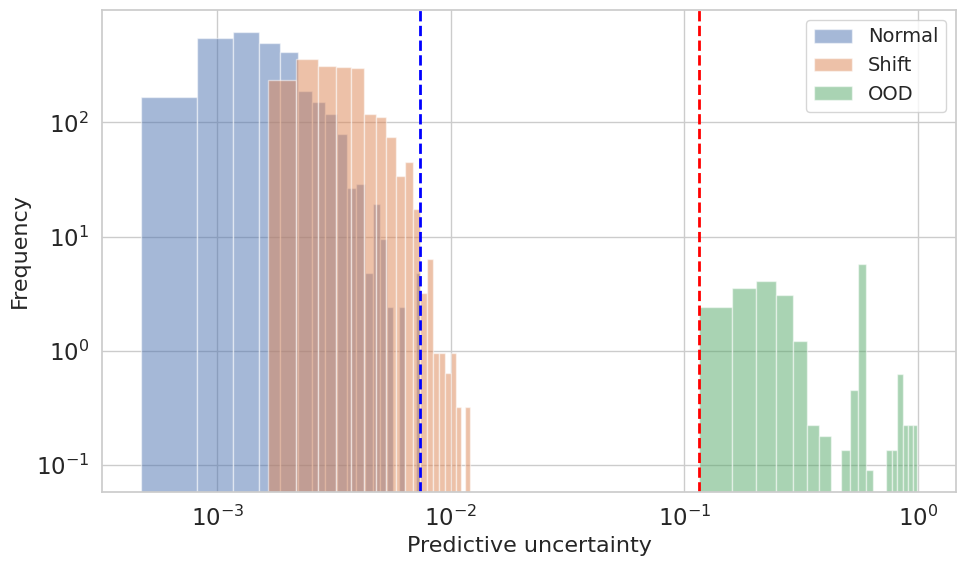

In [ ]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1) = plt.subplots(1,1, figsize=(10, 6), layout='constrained' )

ax1.hist(test_var_sngp,  bins = 20, alpha= 0.5, density=True, label = 'Normal') 

plt.axvline(x= test_var_sngp.max(), color = 'blue', lw = 2, ls = '--' )
print(test_var_sngp.max())
ax1.hist(shift_var_sngp, bins = 20, alpha= 0.5, density=True, label = 'Shift')
plt.axvline(x= OOD_var_sngp.min(), color = 'red', lw = 2, ls = '--')
print(OOD_var_sngp.min())
ax1.hist(OOD_var_sngp,   bins = 20, alpha= 0.5, density=True, label = 'OOD')

ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Predictive uncertainty', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
# ax1.set_title('Proposed method', fontweight="bold")
plt.tight_layout()
plt.savefig('var_risk_reg.pdf')